In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
import json
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import copy

import pandas as pd

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [2]:
class SlotIntentDataset(Dataset):
    
    def __init__(self, datapath):
        self.data = []
        with open(datapath, 'r') as jsonl_file:
            for line in jsonl_file:
                self.data.append(json.loads(line))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.data[idx]['input'], ", ".join(self.data[idx]['user_contacts']), self.data[idx]['output'])

def dl_collate_fn(batch):
    return list(batch)

## Training

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = '/kaggle/input/col772a3-data/A3'

In [4]:
train_ds = SlotIntentDataset(f'{data_path}/train.jsonl')
val_ds = SlotIntentDataset(f'{data_path}/dev.jsonl')

In [5]:
disfluent_words = ['uh', 'uhh', 'um', 'umm', 'uhm','uhmm', 'oh', 'ah', 'er', 'ummm', 'err']

def trim(s):
    s = s.lower()
    if s[-1] == ',':
        s = s[0:-1]
    return s

def remove_disfluency(ds):
    for i in range(len(ds.data)):
        if ds.data[i]['pattern'] != 'disfluency':
            continue
        words_list = ds.data[i]['input'].split(' ')
        last_word = ''
        s_last_word = ''
        for j in range(len(words_list)):
            if(len(words_list[j]) == 0):
                continue
            word = trim(words_list[j])
            if(word in disfluent_words):
                words_list[j] = ''
            elif (word == last_word):
                words_list[j] = ''
            elif (word == s_last_word):
                words_list[j] = ''
            else:
                s_last_word = last_word
                last_word = word
        words_list = list(filter(lambda x: x != '', words_list))        
        ds.data[i]['input'] = " ".join(words_list)
    return ds

def remove_disfluency_val(ds):
    for i in range(len(ds.data)):
        words_list = ds.data[i]['input'].split(' ')
        last_word = ''
        s_last_word = ''
        for j in range(len(words_list)):
            if(len(words_list[j]) == 0):
                continue
            word = trim(words_list[j])
            if(word in disfluent_words):
                words_list[j] = ''
            elif (word == last_word):
                words_list[j] = ''
            elif (word == s_last_word):
                words_list[j] = ''
            else:
                s_last_word = last_word
                last_word = word
        words_list = list(filter(lambda x: x != '', words_list))        
        ds.data[i]['input'] = " ".join(words_list)
    return ds

In [6]:
train_ds = remove_disfluency(train_ds)
val_ds = remove_disfluency_val(val_ds)

In [7]:
DEBUG = False
if DEBUG:
    train_ds.data = train_ds.data[:128]
    val_ds.data = val_ds.data[:64]

In [8]:
train_dl = DataLoader(train_ds, batch_size=16, num_workers=2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=2, shuffle=False)

In [9]:
model = transformers.GPT2LMHeadModel.from_pretrained("gpt2").to(device)
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [10]:
def process_batch(batch, tokenizer):
    encoder_strs = [f'[{b}] {a}: {c}' for a,b,c in zip(batch[0], batch[1], batch[2])]

    return tokenizer(encoder_strs, return_tensors="pt", padding=True, truncation=True).to(device)

In [11]:
def train(model, tokenizer, train_dl, val_dl, optimizer, scheduler=None, max_epochs=20, patience_lim=2):

    best_model = None
    best_val_loss = 10000
    val_losses = []
    train_losses = []
    patience = 0

    for epoch in range(max_epochs):

        print(f'Epoch {epoch}:')
        train_loss = torch.tensor(0, dtype=torch.float, device=device)
        model.train()
        for batch in tqdm(train_dl):
            proc_batch = process_batch(batch, tokenizer)
            
            optimizer.zero_grad()
            loss = model(**proc_batch, labels=proc_batch['input_ids']).loss
            loss.backward()
            optimizer.step()

            train_loss += loss.detach()
        
        if scheduler:
            scheduler.step()

        train_loss = train_loss.cpu()
        train_loss /= len(train_dl)
        print(f' Train Loss: {train_loss}')
        train_losses.append(train_loss)

        val_loss = torch.tensor(0, dtype=torch.float, device=device)
        true_labels = []
        pred_labels = []
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dl):
                proc_batch = process_batch(batch, tokenizer)

                loss = model(**proc_batch, labels=proc_batch['input_ids']).loss

                val_loss += loss.detach()
            
        val_loss = val_loss.cpu()
        val_loss /= len(val_dl)
        val_losses.append(val_loss)

        print(f' Val Loss: {val_loss}')
        print('')

        # early stopping
        if val_loss >= best_val_loss:
            if patience >= patience_lim:
                break
            else:
                patience += 1
        else:
            patience = 0
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            best_model = best_model.cpu()
            print(f'best model: {epoch}')
    
    return best_model, (train_losses, val_losses)

In [12]:
best_model, (train_losses, val_losses) = train(model, tokenizer, train_dl, val_dl, optimizer)
torch.save(best_model, 'intent-slot-gpt2.pt')

Epoch 0:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.6280741691589355


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.3457874059677124

best model: 0
Epoch 1:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.2450401782989502


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.279392123222351

best model: 1
Epoch 2:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.193067193031311


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.2524704933166504

best model: 2
Epoch 3:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.161623239517212


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.2373723983764648

best model: 3
Epoch 4:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.145387887954712


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.2270978689193726

best model: 4
Epoch 5:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.1253330707550049


  0%|          | 0/290 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x785d27cf59e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x785d27cf59e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

 Val Loss: 1.2209995985031128

best model: 5
Epoch 6:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.115555763244629


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.216357707977295

best model: 6
Epoch 7:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.1084240674972534


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.2133409976959229

best model: 7
Epoch 8:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.1043055057525635


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.2091866731643677

best model: 8
Epoch 9:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.0928308963775635


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.2063405513763428

best model: 9
Epoch 10:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.0877808332443237


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.2054150104522705

best model: 10
Epoch 11:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.0754414796829224


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.2059850692749023

Epoch 12:


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x785d27cf59e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.0733247995376587


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.202770709991455

best model: 12
Epoch 13:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.0717146396636963


  0%|          | 0/290 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x785d27cf59e0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x785d27cf59e0>Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():    if w.is_alive():

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/opt/conda/lib/python3.7/multiprocessing/process.py", l

 Val Loss: 1.2018084526062012

best model: 13
Epoch 14:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.0663844347000122


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.2004019021987915

best model: 14
Epoch 15:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.061507225036621


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.1999573707580566

best model: 15
Epoch 16:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.0541918277740479


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.1992676258087158

best model: 16
Epoch 17:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.0526739358901978


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.1990879774093628

best model: 17
Epoch 18:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.0506489276885986


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.1989808082580566

best model: 18
Epoch 19:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 1.0432409048080444


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 1.1993306875228882



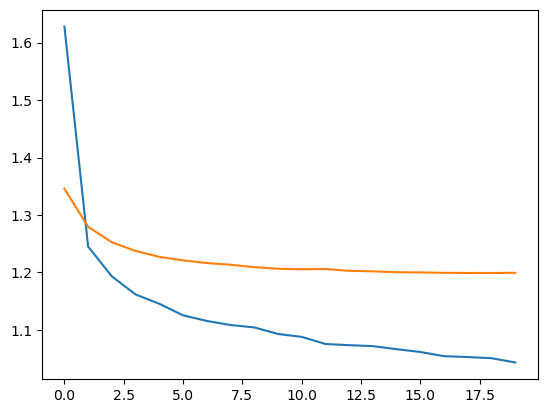

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)

In [14]:
def generate(model, tokenizer, dl):

    pred_gens = []
    gold_gens = []
    
    model.eval()
    for batch in tqdm(dl):
        encoder_toks = process_batch_eval(batch, tokenizer)
        enc_len = encoder_toks['input_ids'].size(1)

        # beam search generations for syntax rather than nucleus sample
        gen = model.generate(
            **encoder_toks,
            num_beams=5,
            max_new_tokens=100,
        )
        
        pred_gens += tokenizer.batch_decode(gen[:,enc_len:], skip_special_tokens=True)
        gold_gens += batch[2]
    
    return pred_gens, gold_gens

In [15]:
eval_tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2", padding_side='left')
eval_tokenizer.pad_token = eval_tokenizer.eos_token

In [16]:
def process_batch_eval(batch, tokenizer):
    encoder_strs = [f'[{b}] {a}: \xa0' for a,b,c in zip(batch[0], batch[1], batch[2])]

    return tokenizer(encoder_strs, return_tensors="pt", padding=True, truncation=True).to(device)

In [17]:
with torch.no_grad():
    pred_gens, gold_gens = generate(model, eval_tokenizer, val_dl)

  0%|          | 0/290 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [18]:
def matches(y1, y2):
    return ("".join(y1.split()) == "".join(y2.split()))

def exact_match_metric(gold, pred):
    cnt_correct = 0
    for i in range(len(gold)):
        if(matches(gold[i], pred[i])):
            
            cnt_correct += 1
    return cnt_correct/len(gold)

In [19]:
exact_match_metric(gold_gens, pred_gens)

0.7462251941328731